In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from junctionart.roundabout.encodingGFN.gflownet.gflownet import GFlowNet
from junctionart.roundabout.encodingGFN.policy import ForwardPolicy, BackwardPolicy
from junctionart.roundabout.encodingGFN.setGenerationEnv import SetGenerationEnv
from junctionart.roundabout.encodingGFN.gflownet.utils import trajectory_balance_loss
from torch.optim import Adam
from tqdm import tqdm
import torch 

size = 5
nActions = 30
losses = []
rewards = []

flows = []
threePoints = [
            {"x": 80, "y": 20, "heading": math.radians(30),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
            {"x": 210, "y": 20, "heading": math.radians(145),'leftLane': 1, 'rightLane': 2, 'medianType': None, 'skipEndpoint': None},
            # {"x": 120, "y": 110, "heading": math.radians(280),'leftLane': 2, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
        ]


# threePoints should not really be a part of setEnv. TO-DO: fix that later
setEnv = SetGenerationEnv(size, nActions, threePoints)

def train(batch_size, num_epochs, hidden_dim):
    forward_policy = ForwardPolicy(setEnv.state_dim, hidden_dim=hidden_dim, num_actions=setEnv.num_actions)
    backward_policy = BackwardPolicy(setEnv.state_dim, num_actions=setEnv.num_actions)
    
    model = GFlowNet(forward_policy, backward_policy, setEnv)

    opt = Adam([
        {"params": model.forward_policy.parameters()},
        {"params": model.total_flow, "lr": 5e-2},
    ],
    lr=5e-5)
    
    for i in (p := tqdm(range(num_epochs))):
        s0 = torch.zeros(batch_size, size).float()
   
        s, log, traj_length = model.sample_states(s0, return_log=True)

        loss = trajectory_balance_loss(log.total_flow,
                                       log.rewards,
                                       log.fwd_probs,
                                       log.back_probs)

        
        flows.append(model.total_flow.item())
        rewards.append(log.rewards.mean())
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)
        opt.step()
        opt.zero_grad()
        if i % 10 == 0: p.set_description(f"{loss.item():.3f} T.L : {traj_length}")

    return model, losses, rewards, flows

batch_size = 128
num_epochs = 1000

# model, losses, rewards, flows = train(batch_size, num_epochs)

In [3]:
import seaborn as sns
import pandas as pd
nIter = 1
nBatch = 10**5
def getDistinctModes(nIter, nBatch, model):
    terminalStates = []
    for i in tqdm(range(nIter)):
        s0 = torch.zeros(nBatch, size).float()
        s, traj_length = model.sample_states(s0, return_log=False)
        terminalStates.append(s)

    s = torch.concat(terminalStates)

    statesForPlot = setEnv.getStateForm(s).long().tolist()
    rewardsForPlot = setEnv.reward(s, showProgress=True).tolist()

    cnts = []
    cnt = 0

    stateDict = {}
    for i in tqdm(range(len(statesForPlot))):
        state = str(statesForPlot[i])
        if state in stateDict:
            reward, freq = stateDict[state]
            stateDict[state] = (reward, freq + 1)
        else:
            stateDict[state] = (rewardsForPlot[i], 1)
            if rewardsForPlot[i] >= 10000**0.85:
                cnt += 1
        cnts.append(cnt)        
    
    return cnts


In [16]:
cntsByHiddenLayer = []
for hiddenLayer in [32, 64, 128, 256, 512, 1024]:
    batch_size = 128
    num_epochs = 1000
    model, losses, rewards, flows = train(batch_size, num_epochs, hidden_dim=hiddenLayer)
    nIter = 1
    nBatch = 10**5
    cnts = getDistinctModes(nIter, nBatch=nBatch, model=model)
    cntsByHiddenLayer.append({"Hidden Dim" : hiddenLayer, "cnts" : cnts})

100%|███████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 922473.83it/s]


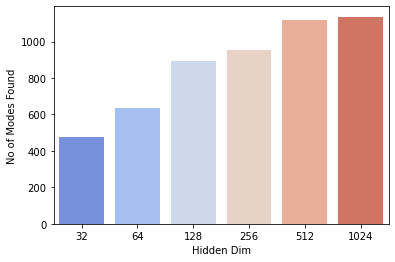

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cntByHiddenLayer = [{"Hidden Dim" : _["Hidden Dim"], "No of Modes Found" : _["cnts"][-1]} for _ in cntsByHiddenLayer]
df = pd.DataFrame(cntByHiddenLayer)

sns.barplot(data=df, x = "Hidden Dim", y = "No of Modes Found", palette=sns.color_palette('coolwarm', n_colors=6)) 
plt.savefig("figs/ablationHidden.png", dpi=300)

<AxesSubplot:xlabel='Iteration', ylabel='No of Modes Found'>

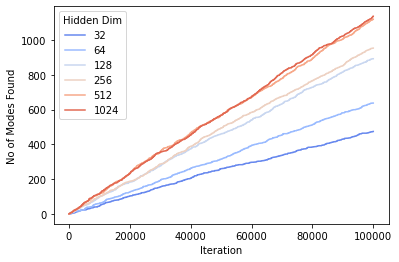

In [23]:
cnts = {"No of Modes Found" : [], "Iteration" : [], "Hidden Dim" : []}
for _ in cntsByHiddenLayer:
    hiddenDim = _["Hidden Dim"]
    cntByIter = _["cnts"]
    for i, cnt in enumerate(cntByIter):
        cnts["No of Modes Found"].append(cnt)
        cnts["Iteration"].append(i + 1)
        cnts["Hidden Dim"].append(hiddenDim)
df = pd.DataFrame(cnts)

sns.lineplot(data=df, x="Iteration", y="No of Modes Found", hue="Hidden Dim", palette=sns.color_palette('coolwarm', n_colors=6))